# Single Cell RNASeq Data Analysis of 7.5k Sorted Cells from Human Invasive Ductal Carcinoma **using** Scanpy

In [2]:
!pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.9 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=c3c1a5da23c2a721916c28eaf0c9d94dbb1d9f98811821e27aa0ba0bc76e7830
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [119]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.25.2 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.2.2 statsmodels==0.14.2 pynndescent==0.5.12


In [5]:
results_file = "write/Breast_Cancer_3p.h5ad"  # the file that will store the analysis results

In [9]:
import os
cwd = os.getcwd()

In [10]:
file_path = os.path.join(cwd, "C/Users/Dr Medite/Desktop/Breast_Cancer_3p_filtered_gene_bc_matrices/hg19/matrix.mtx.gz")

In [14]:
!tar -xzf Breast_Cancer_3p_filtered_gene_bc_matrices.tar.gz

In [16]:
adata = sc.read_10x_mtx(
    "/content/Breast_Cancer_3p_filtered_gene_bc_matrices/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... writing an h5ad cache file to speedup reading next time


In [17]:
!mkdir write

In [18]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [19]:
adata

AnnData object with n_obs × n_vars = 5680 × 36601
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


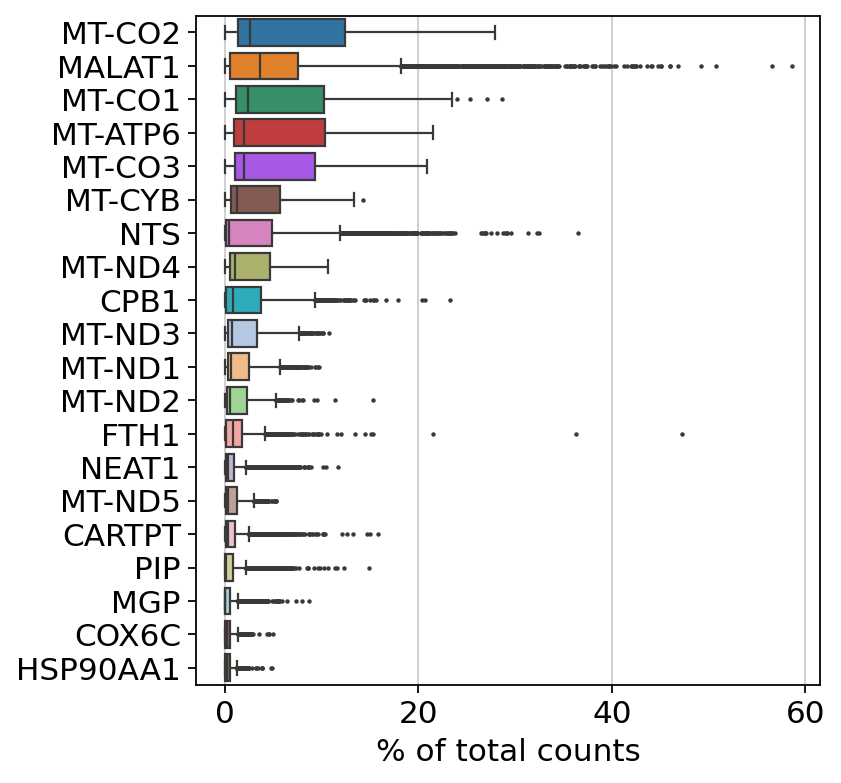

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic Filtering

In [21]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 708 cells that have less than 200 genes expressed
filtered out 13693 genes that are detected in less than 3 cells


High proportions of mitochodrial genes (MT) are indicative of poor-quality cells because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [22]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

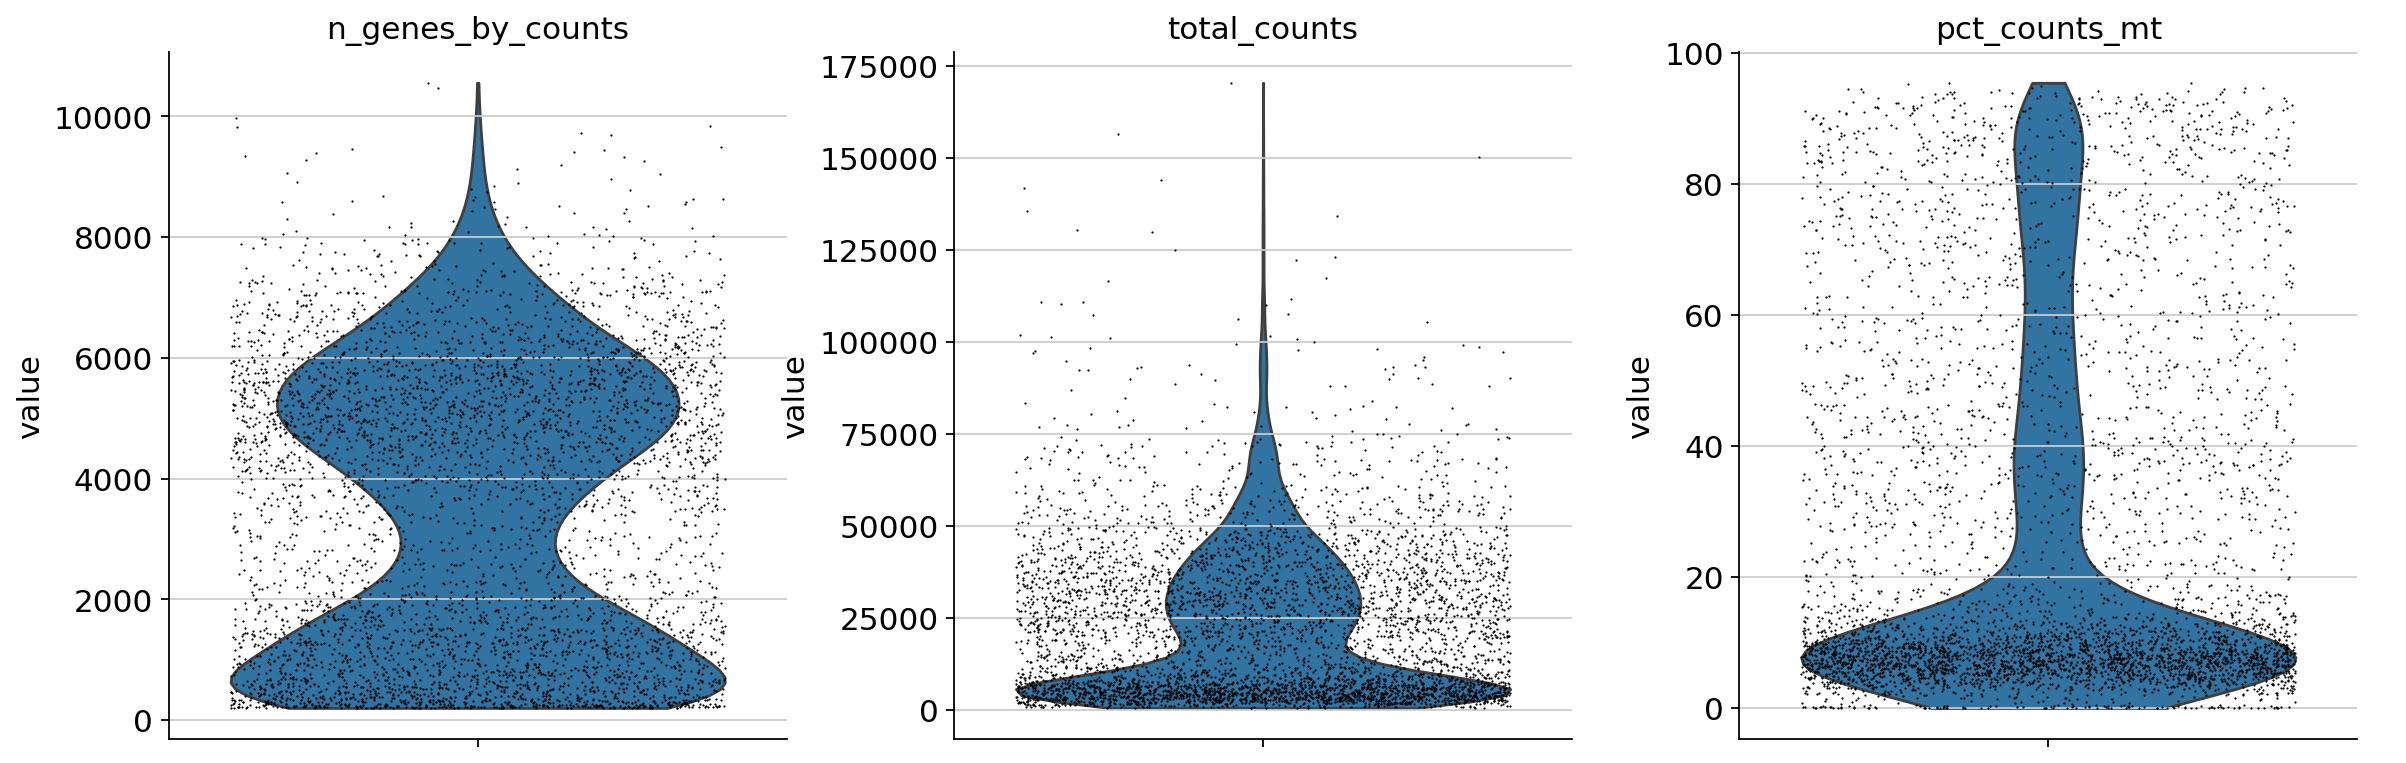

In [23]:
# Violin plot of computed quality measures:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

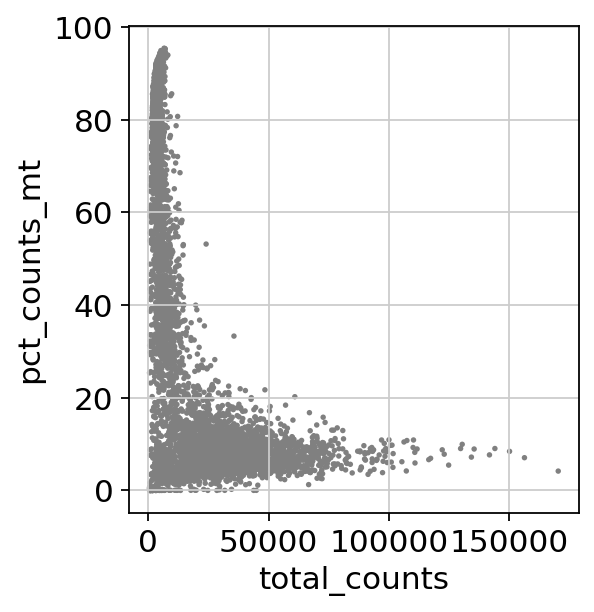

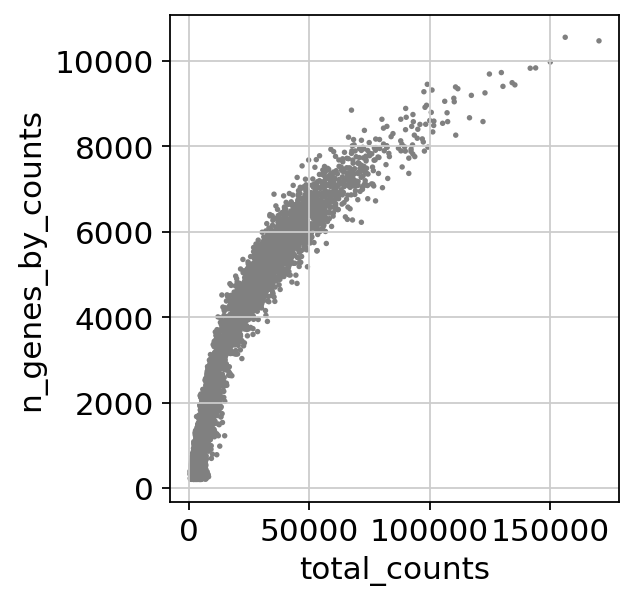

In [26]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [27]:
# Filter by sclicing the AnnData object
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [28]:
# Normalize total count to 10,000 reads per cell, so that counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


In [29]:
# Logarithmize the data
sc.pp.log1p(adata)

In [30]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


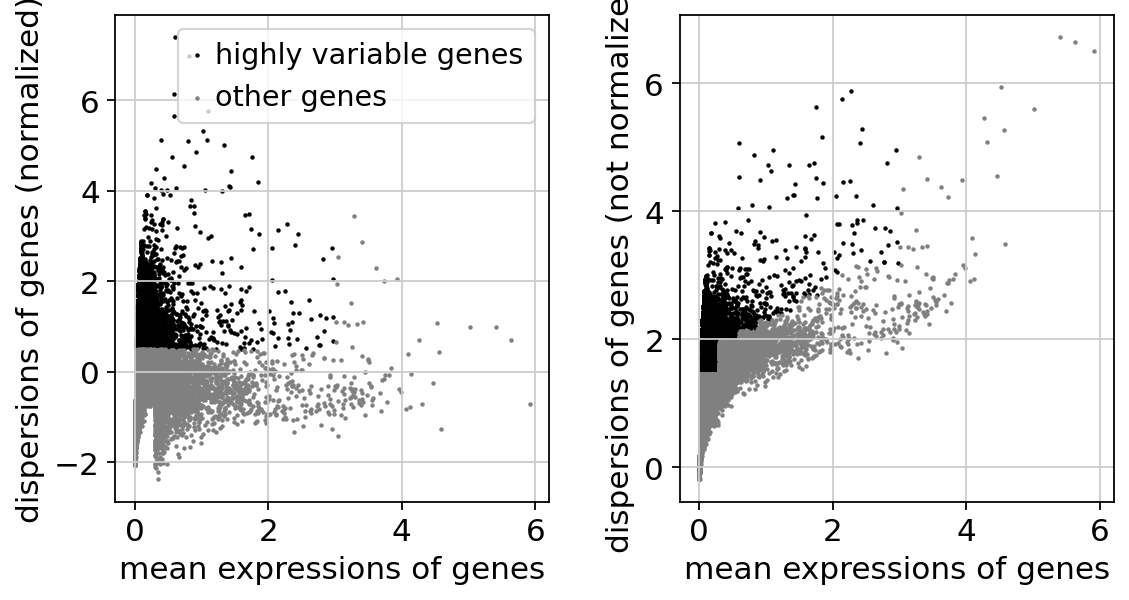

In [31]:
sc.pl.highly_variable_genes(adata)

Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression

In [32]:
adata.raw = adata

In [33]:
# Filter
adata = adata[:, adata.var.highly_variable]

In [34]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:641: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:10)


In [35]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10)

## Principal component analysis
Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [36]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:00)


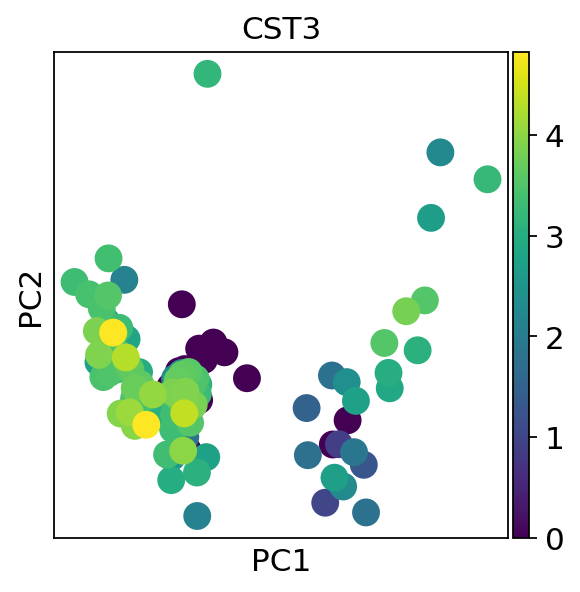

In [37]:
# Make a scatter plot in the PCA coordinates
sc.pl.pca(adata, color="CST3")

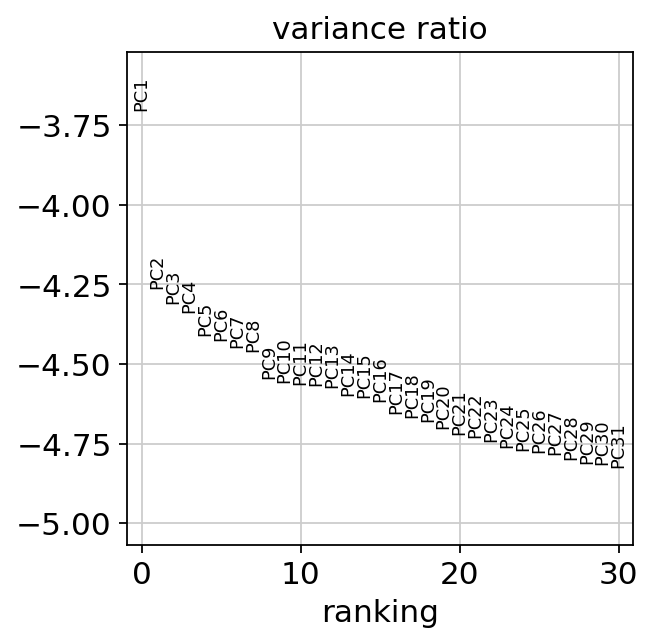

In [38]:
# Inspect the contribution of single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, log=True)

In [39]:
# Save the result
adata.write(results_file)

In [40]:
adata

AnnData object with n_obs × n_vars = 191 × 4401
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

In [41]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


## Embedding the neighborhood graph

In [43]:
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.5 MB/s eta 0:00:00


In [45]:
if 'leiden' not in adata.obs and 'louvain' not in adata.obs:
    print("Community labels not found.")

Community labels not found.


In [46]:
if 'leiden' not in adata.obs:
    sc.tl.leiden(adata)
elif 'louvain' not in adata.obs:
    sc.tl.louvain(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


<ipython-input-46-c84d561763ce>:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [47]:
# Embed the graph in two dimensions using UMAP
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [48]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


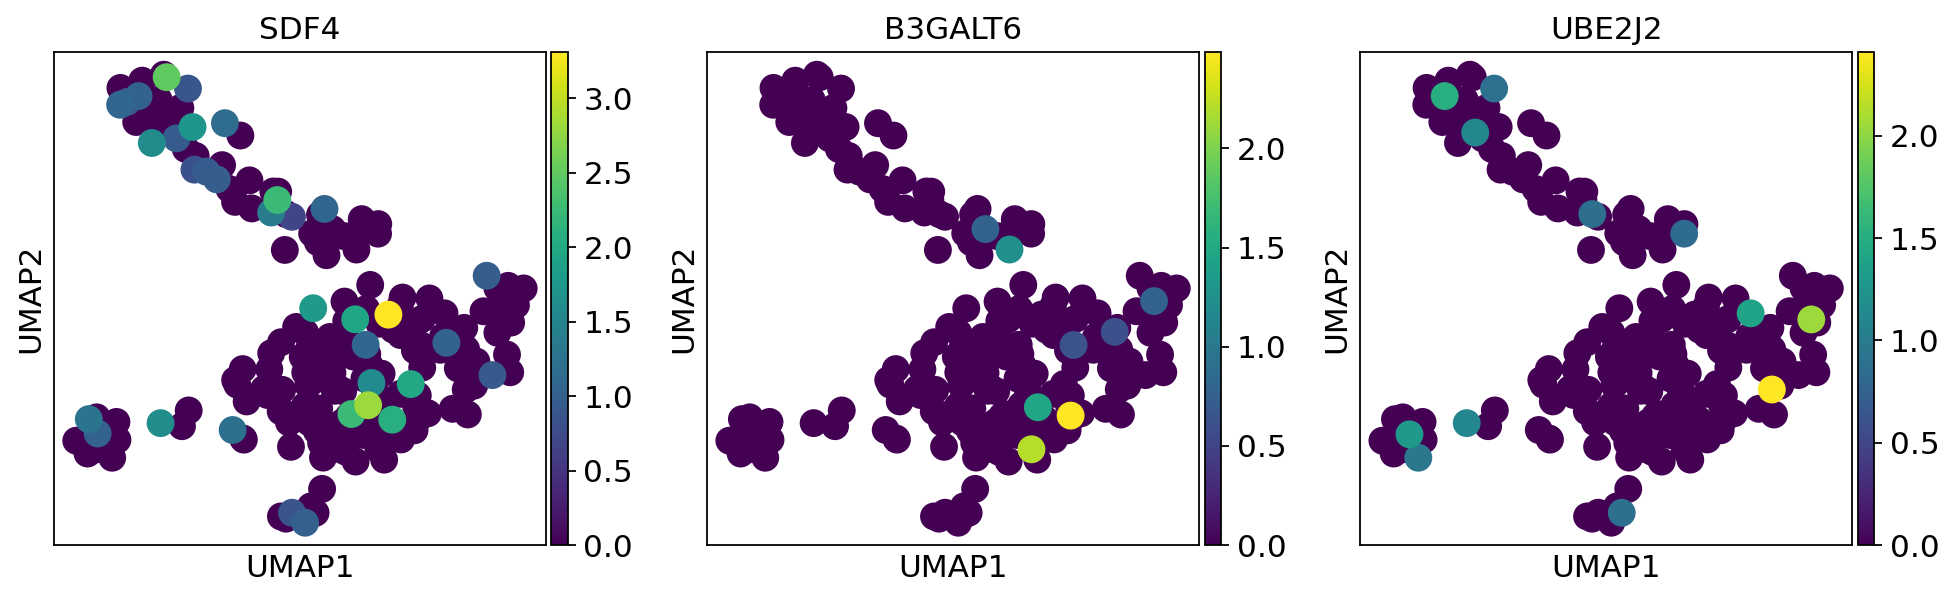

In [63]:
sc.pl.umap(adata, color=["SDF4", "B3GALT6", "UBE2J2"])

In [56]:
print(adata.var_names[:10])

Index(['AP006222.2', 'FAM41C', 'NOC2L', 'HES4', 'ISG15', 'AL390719.2',
       'TNFRSF4', 'SDF4', 'B3GALT6', 'UBE2J2'],
      dtype='object')


In [58]:
print(adata.obs.columns[:10])

Index(['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'leiden'],
      dtype='object')


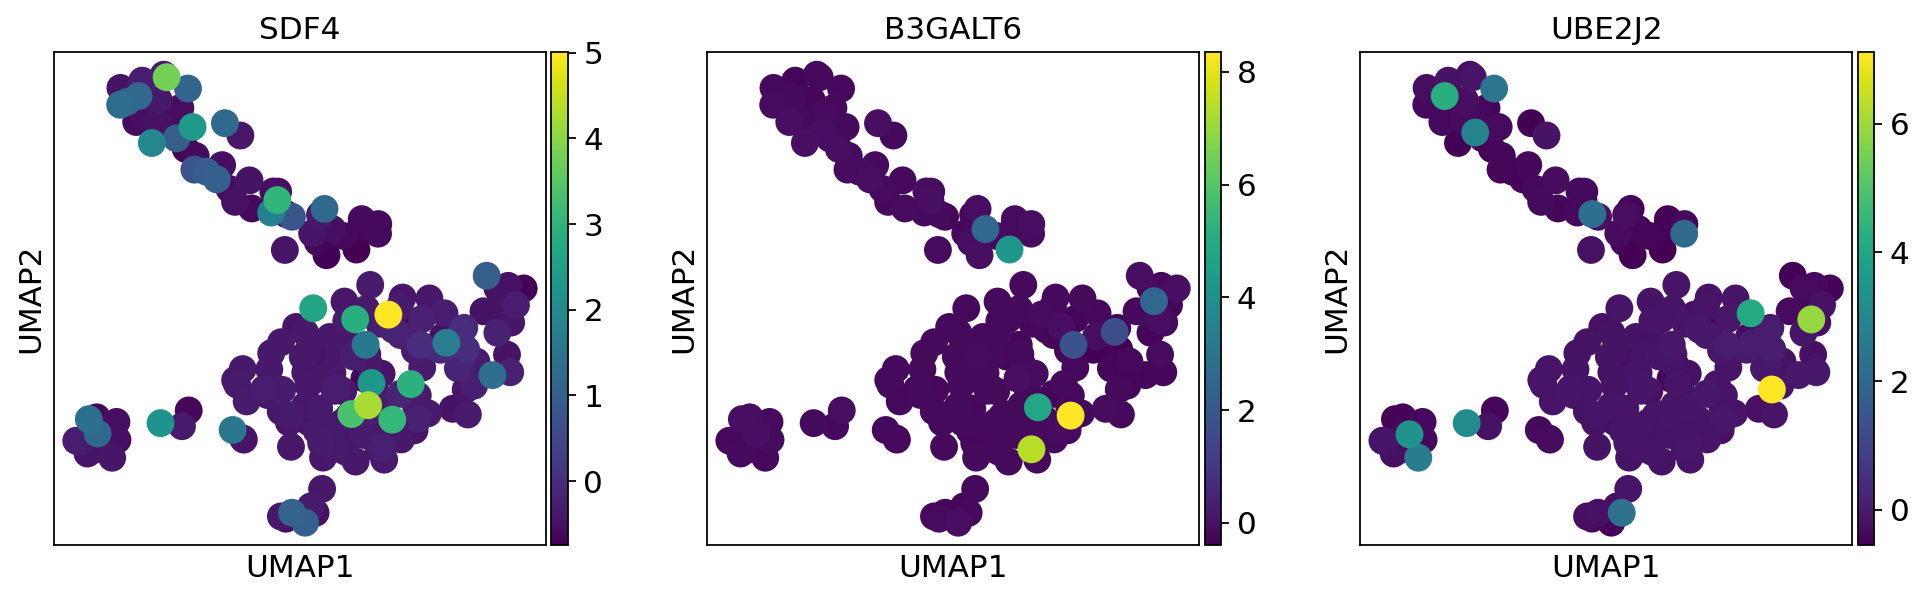

In [62]:
sc.pl.umap(adata, color=["SDF4", "B3GALT6", "UBE2J2"], use_raw=False)

## Clustering the neighborhood graph

In [64]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


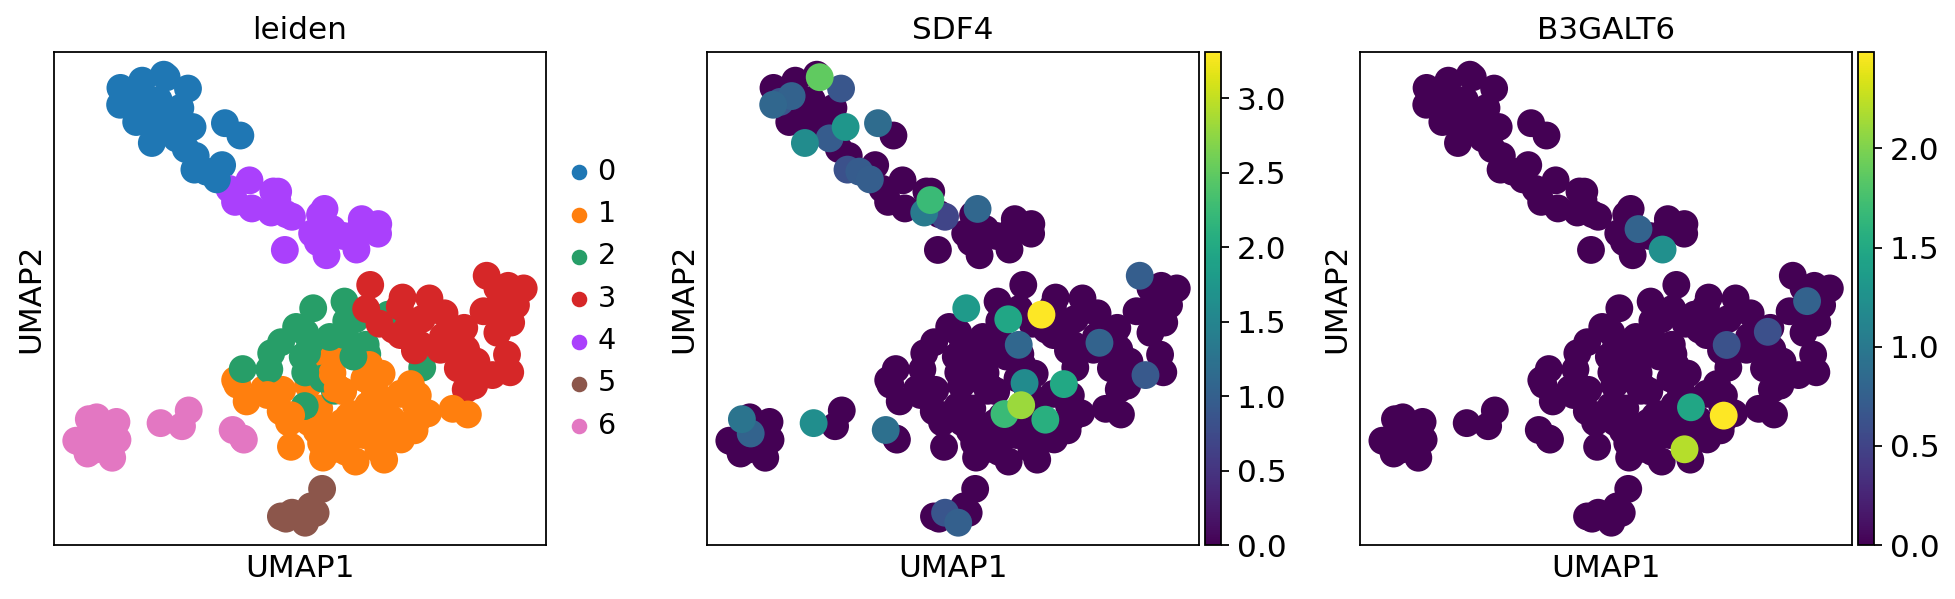

In [65]:
sc.pl.umap(adata, color=["leiden", "SDF4", "B3GALT6"])

In [66]:
# Save the result.

adata.write(results_file)

## Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished (0:00:00)


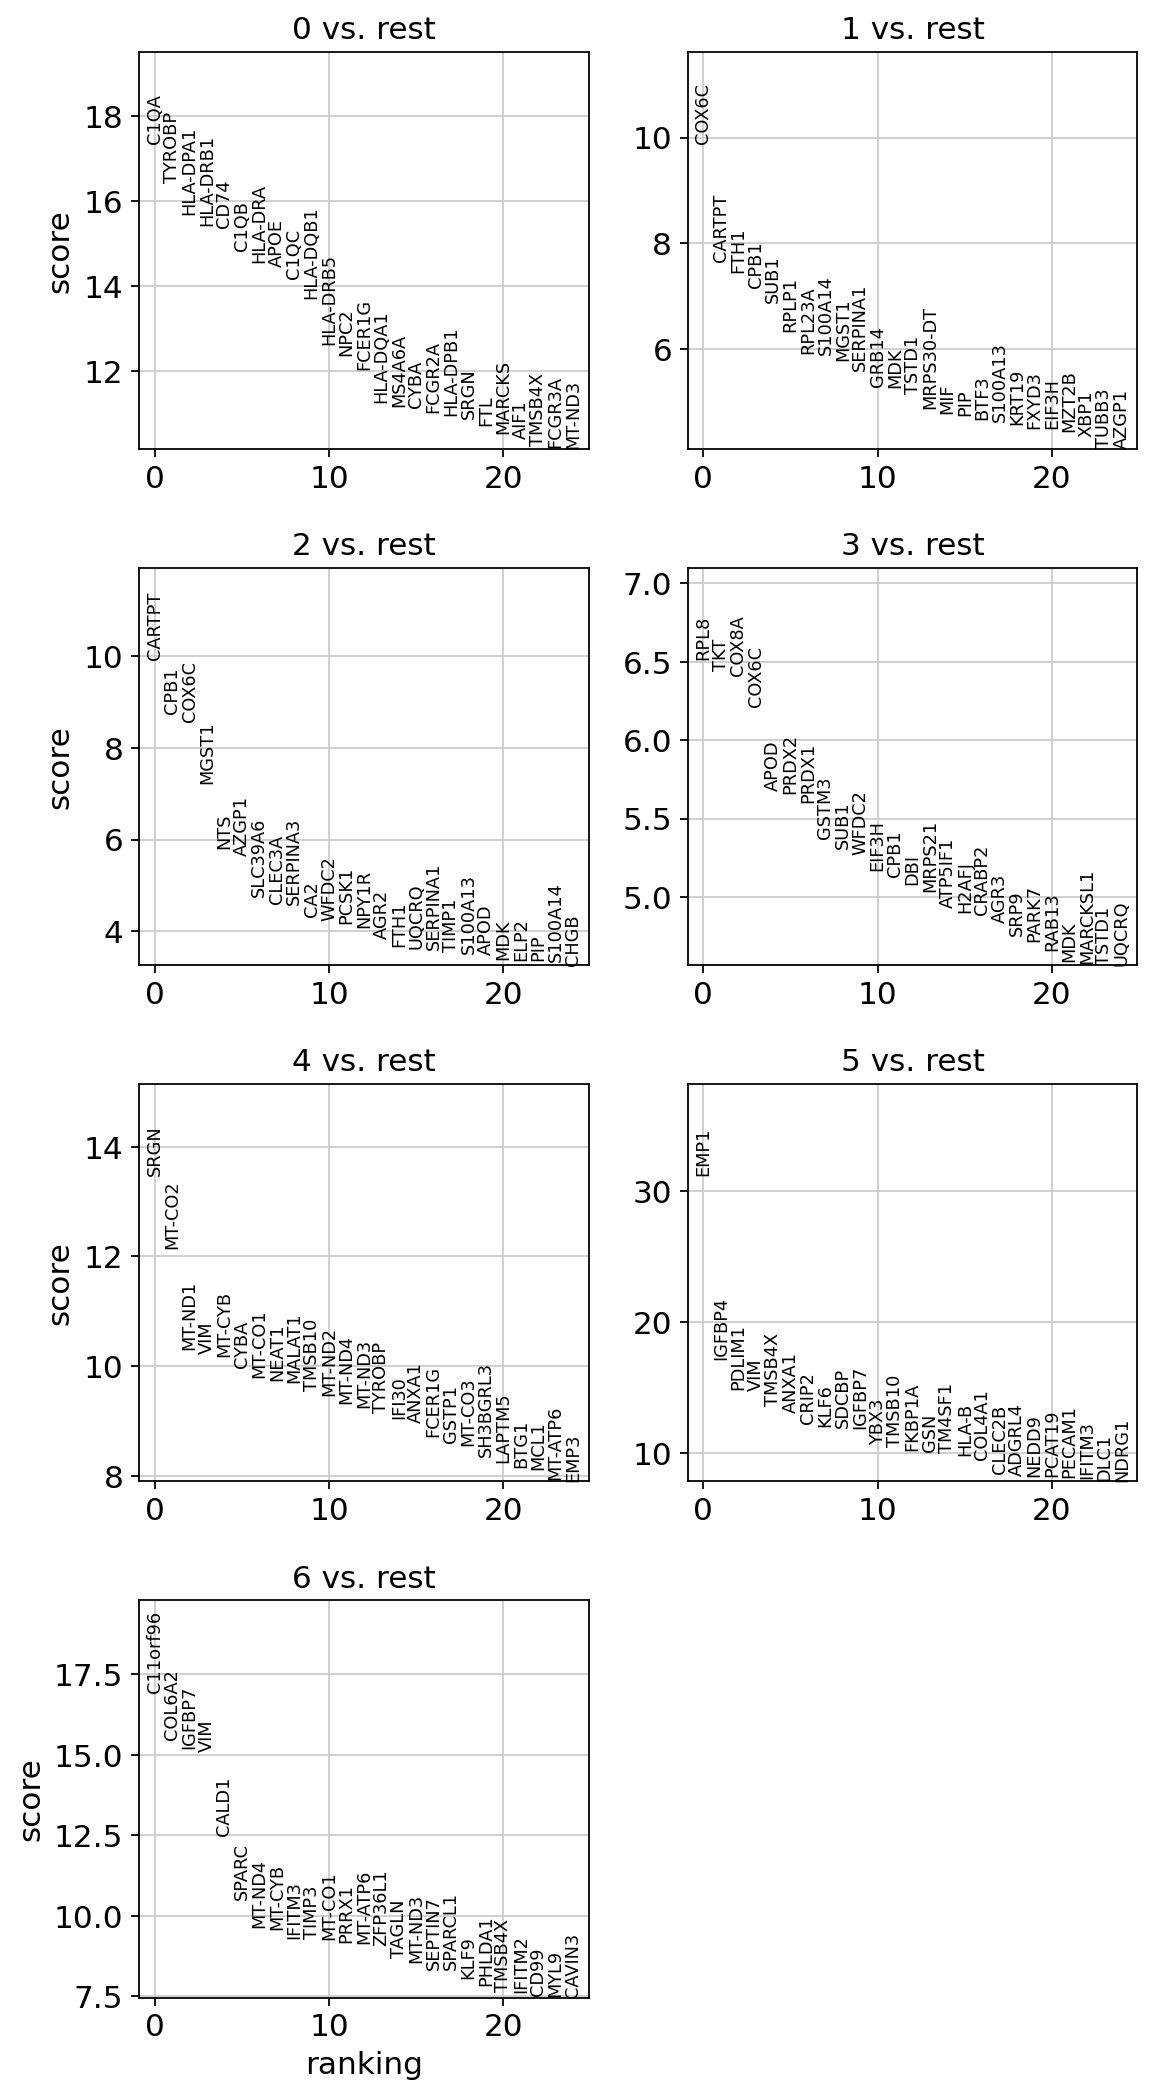

In [117]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test", key_added = "t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "t-test", ncols=2)

In [68]:
sc.settings.verbosity = 2  # reduce the verbosity

In [70]:
# Save the result.

adata.write(results_file)

The result of a Wilcoxon rank-sum (Mann-Whitney-U) test is very similar. We recommend using the latter in publications, see e.g., Sonison & Robinson (2018). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:00)


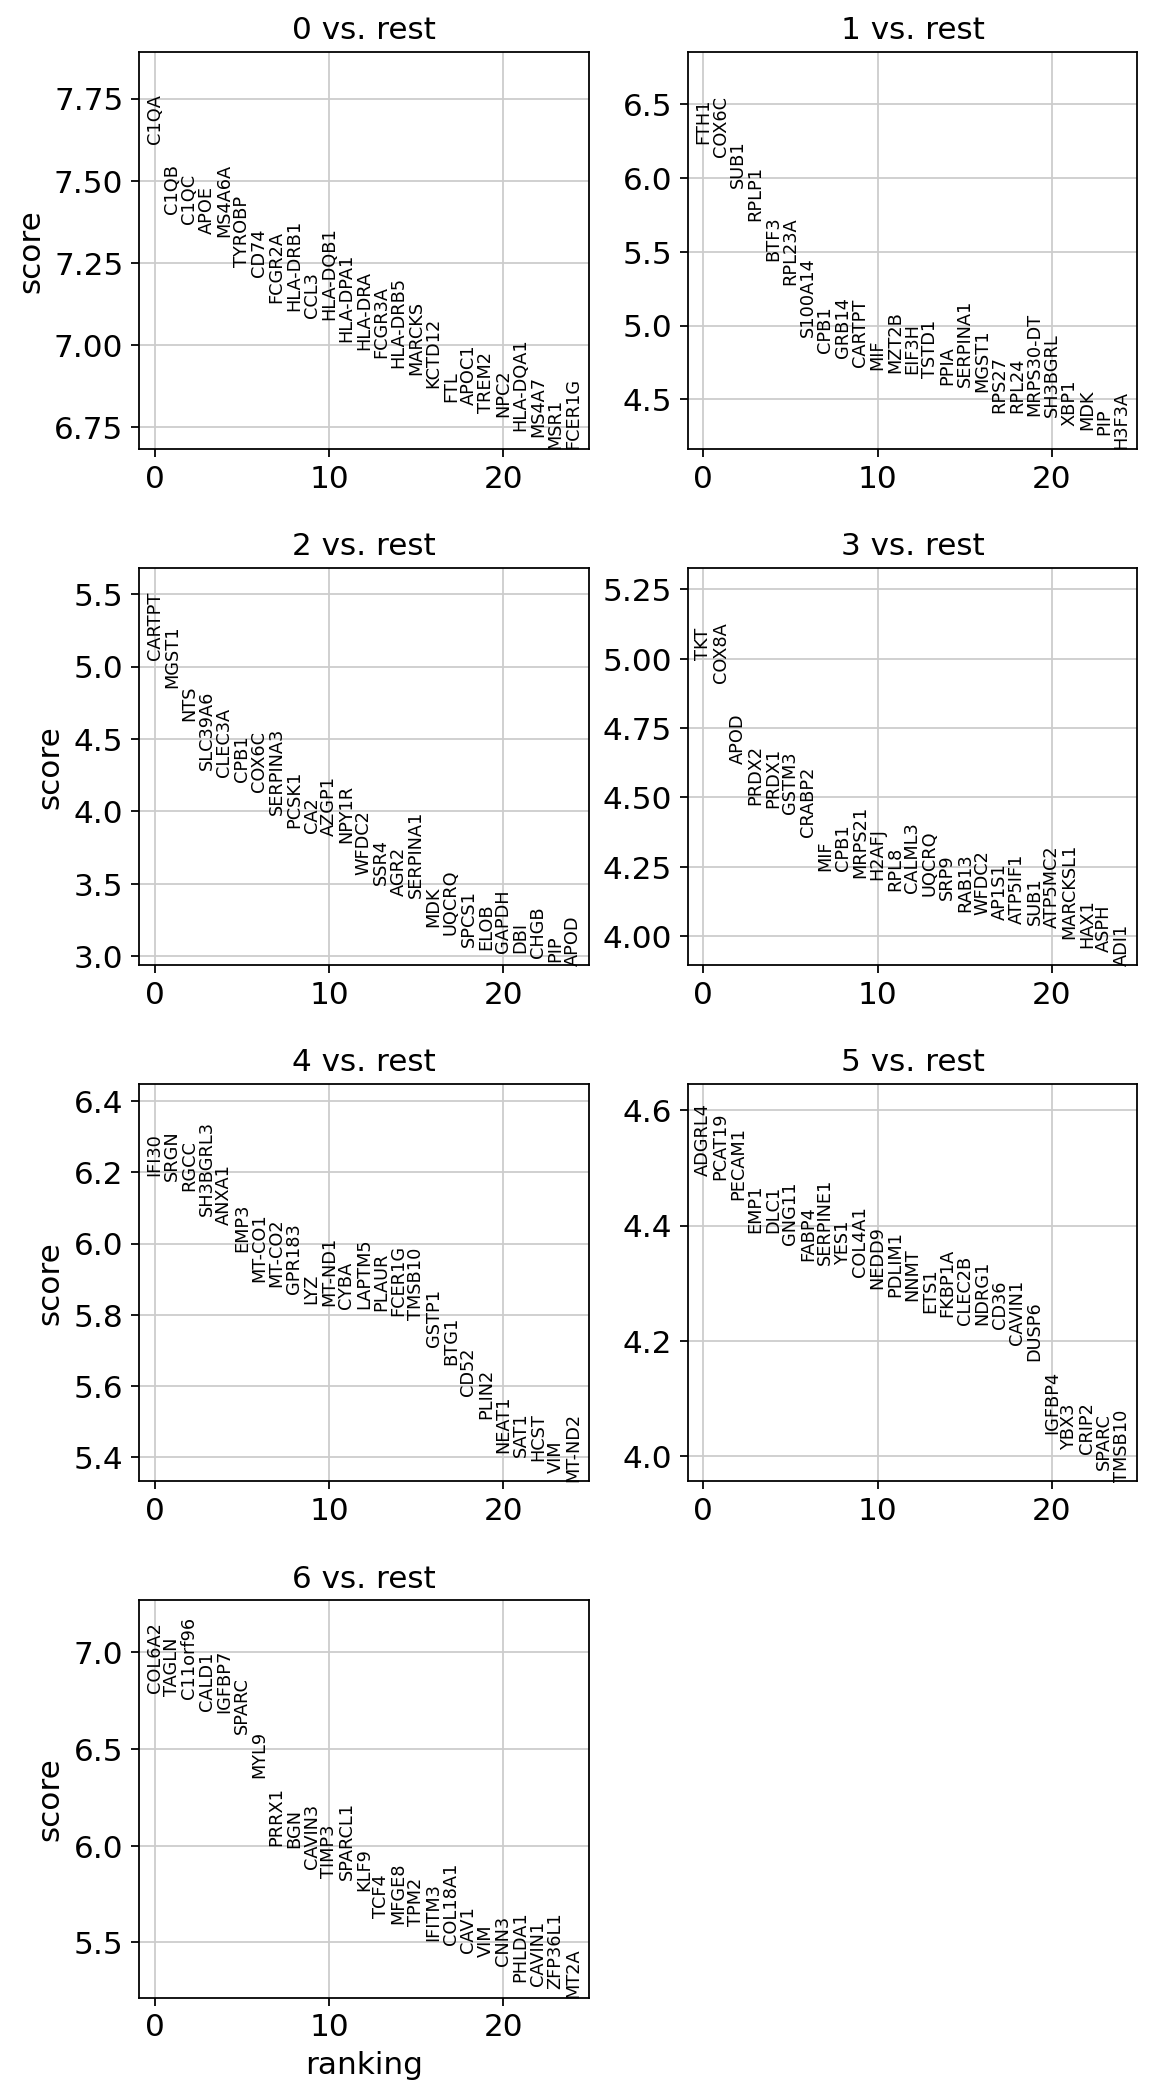

In [105]:
#using wilcoxon rank-sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon", ncols=2)

In [104]:
# Save the result.
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

ranking genes
    finished (0:00:38)


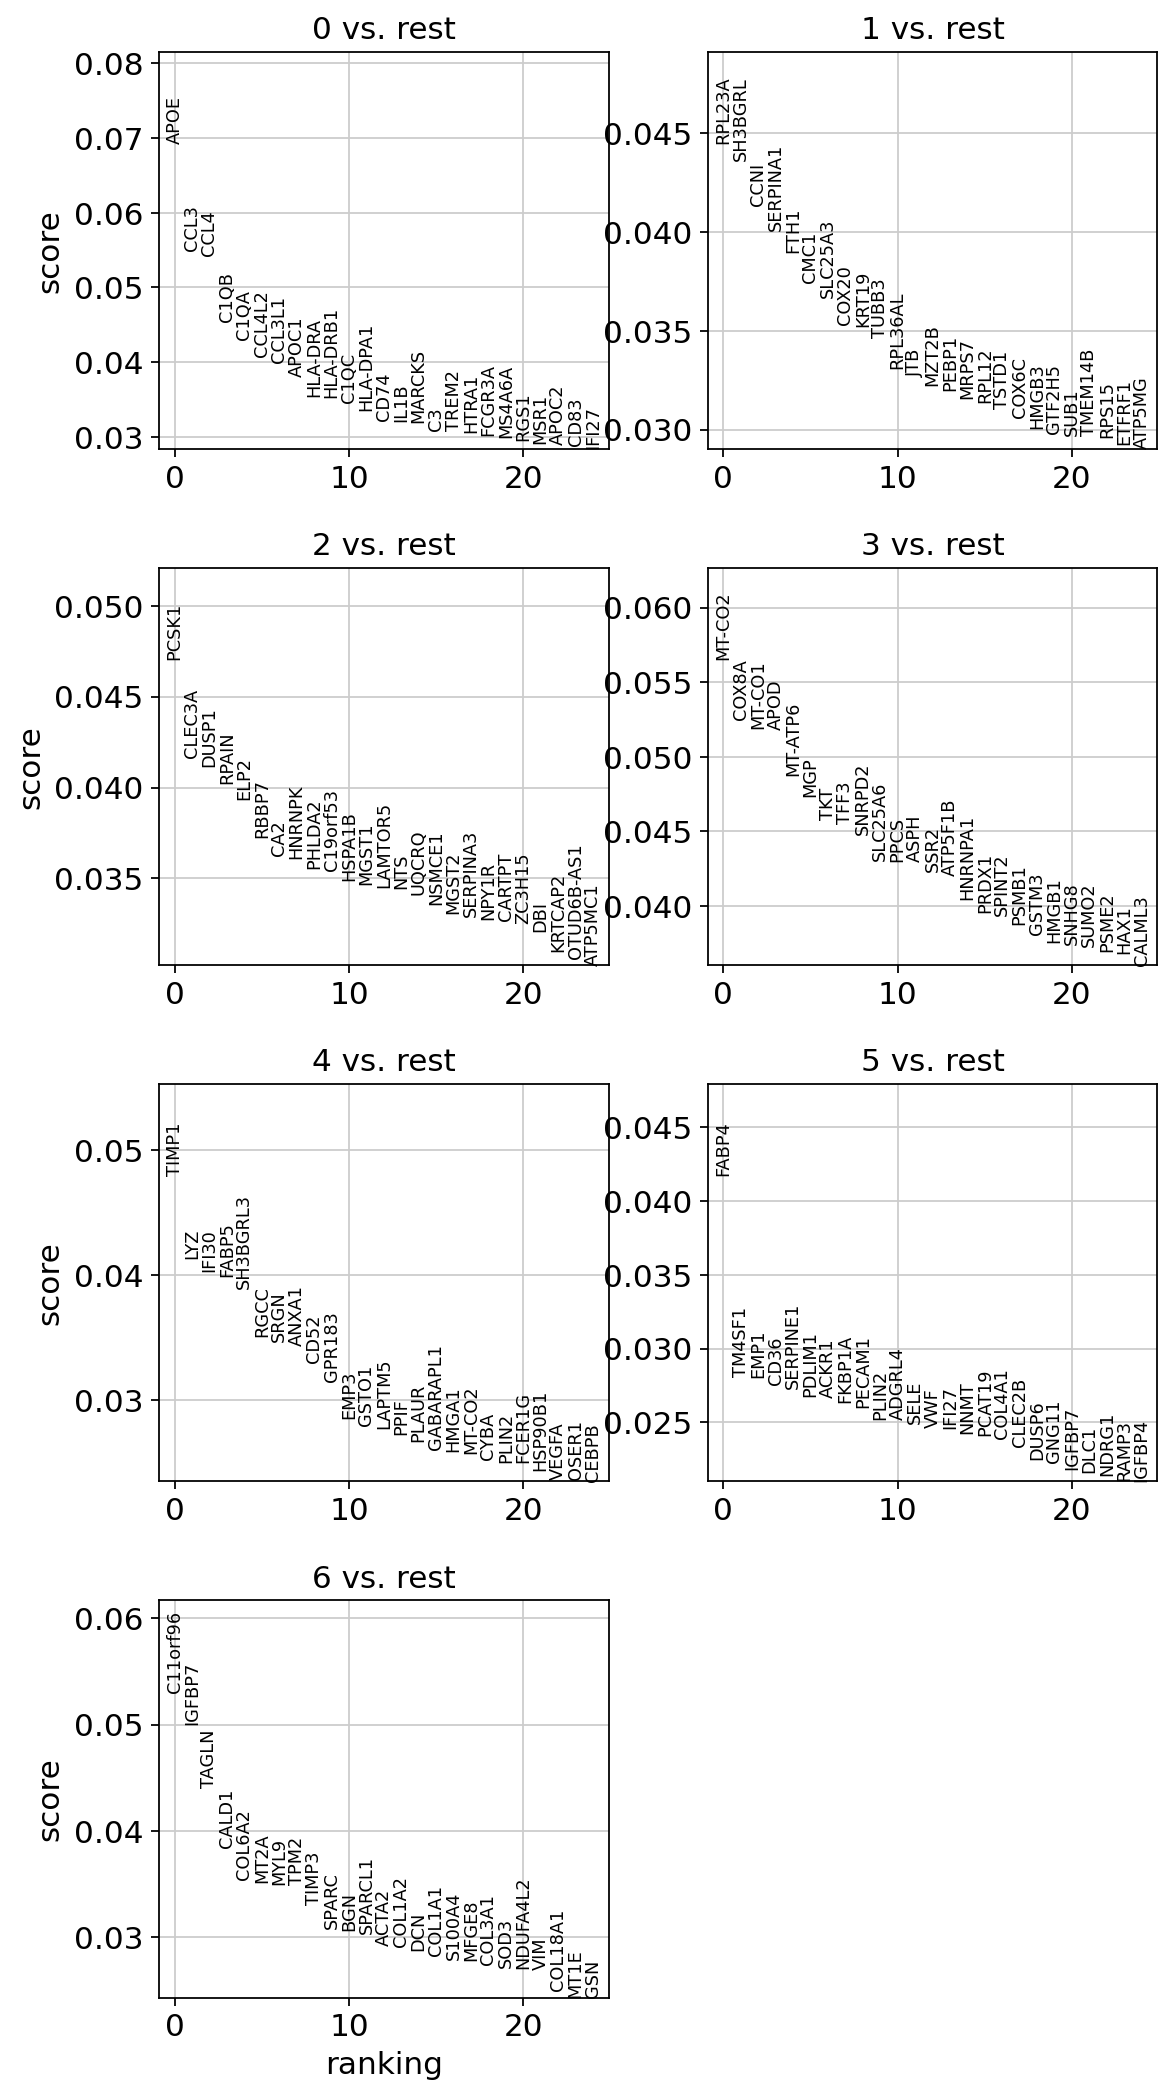

In [129]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000, key_added = "logreg")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "logreg", ncols=2)

In [106]:
# Genes are sorted based on the score for each cluster
# columns names are cluster num
# For example, C1QA gene is found to posess highest score in "cluster_0"
pd.DataFrame(adata.uns['wilcoxon']['names']).head(5)

0      1        2      3         4       5         6
0    C1QA   FTH1   CARTPT    TKT     IFI30  ADGRL4    COL6A2
1    C1QB  COX6C    MGST1  COX8A      SRGN  PCAT19     TAGLN
2    C1QC   SUB1      NTS   APOD      RGCC  PECAM1  C11orf96
3    APOE  RPLP1  SLC39A6  PRDX2  SH3BGRL3    EMP1     CALD1
4  MS4A6A   BTF3   CLEC3A  PRDX1     ANXA1    DLC1    IGFBP7

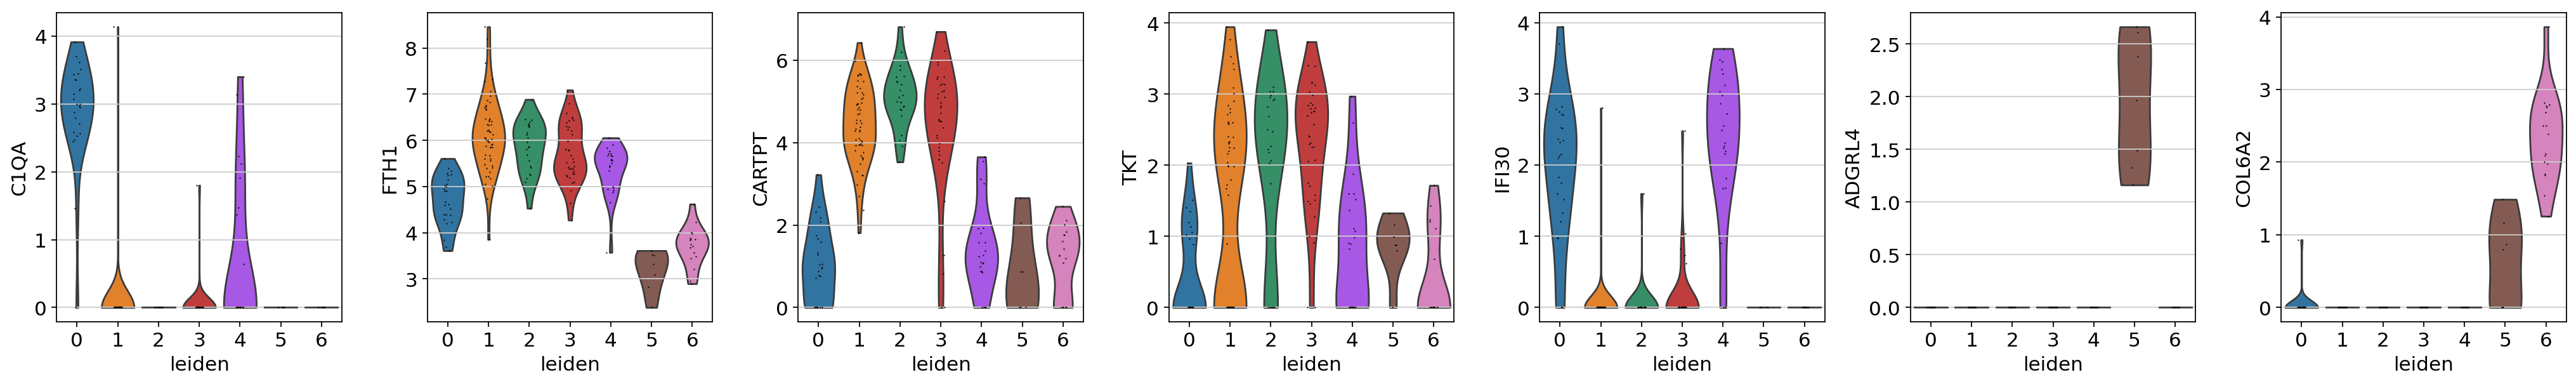

In [112]:
# visualising the expression levels of marker genes within the cluster of cells also helps with annotation.
sc.pl.violin(adata, ['C1QA', 'FTH1', 'CARTPT','TKT','IFI30','ADGRL4','COL6A2'], groupby='leiden')

In [134]:
# save differentially expressed genes (DEGs)  between clusters which are ranked by score
result = adata.uns['wilcoxon']
groups = result['names'].dtype.names
df1 = pd.DataFrame({group+'' + key:result[key][group] for group in groups for key in ['names','scores','logfoldchanges','pvals','pvals_adj']})
#df1.head()
df1.to_csv("Breast_Cancer_3p_DEGs_between_clusters.csv")

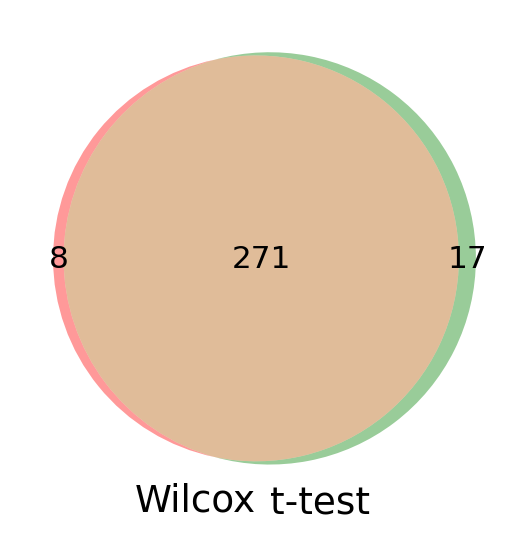

In [133]:
#adata
wc = sc.get.rank_genes_groups_df(adata, group='0', key='wilcoxon', pval_cutoff=0.01, log2fc_min=0)['names']
tt = sc.get.rank_genes_groups_df(adata, group='0', key='t-test', pval_cutoff=0.01, log2fc_min=0)['names']

from matplotlib_venn import venn2

venn2([set(wc),set(tt)], ('Wilcox','t-test') )
plt.show()

## Visualization of Top Differntially Expressed Genes
We will now visualize the expression of the top 5 differentially expressed genes per cluster obtained from the Wilcoxon rank-sum test using various plots such as heatmap, dotplot, violin plot or matrix.

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


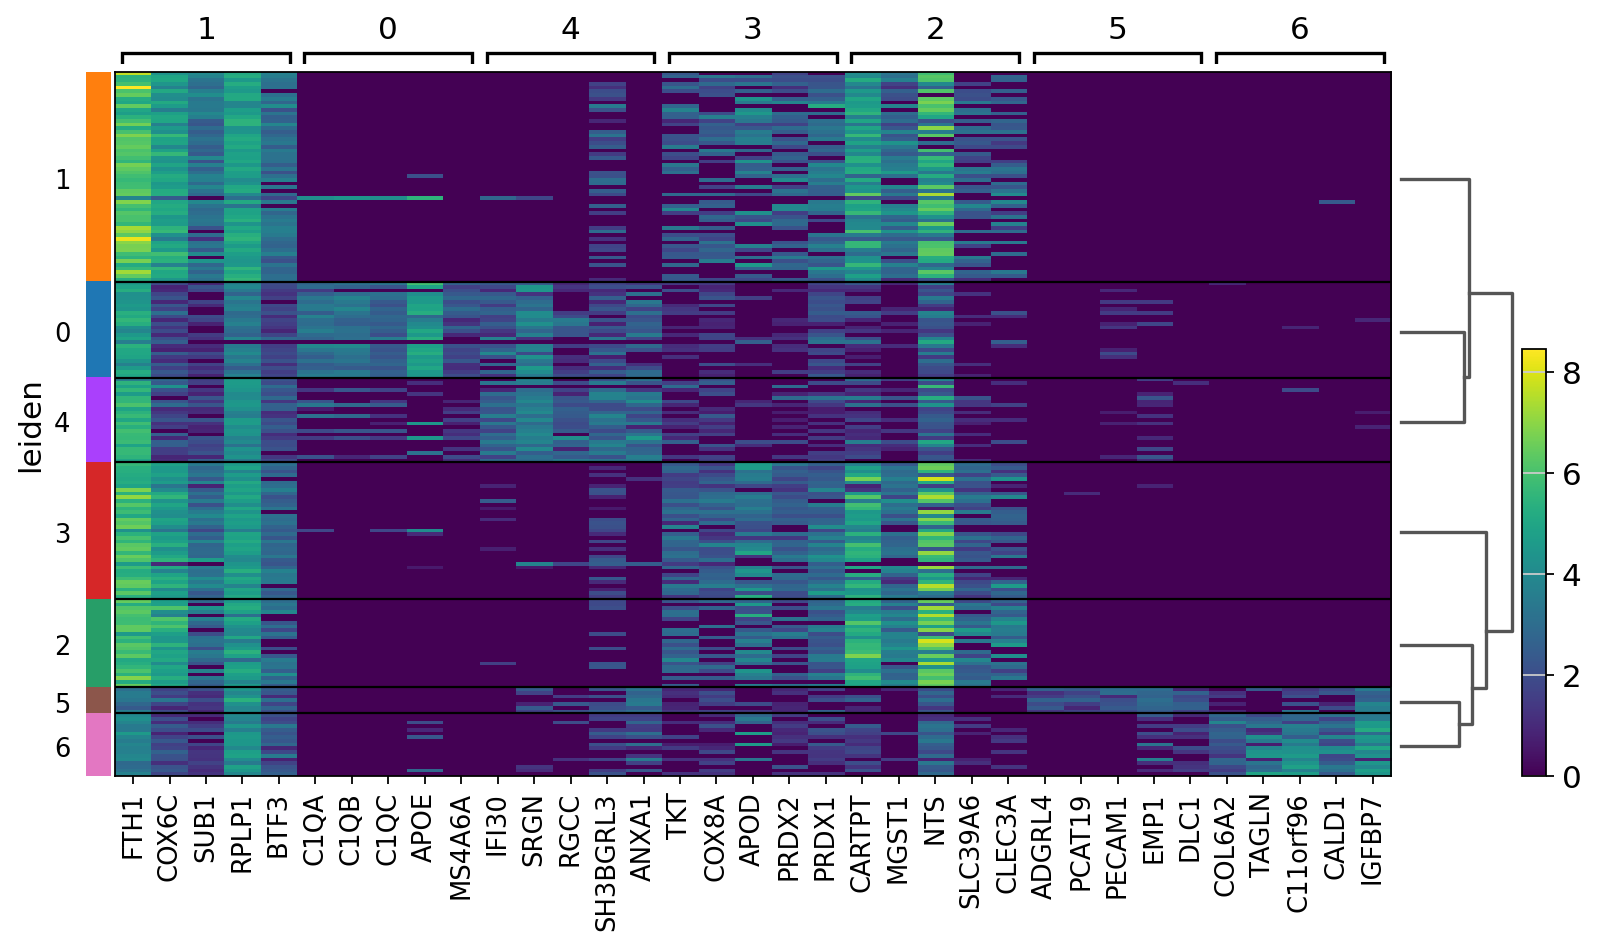

In [121]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5, key="wilcoxon", groupby="leiden", show_gene_labels=True)

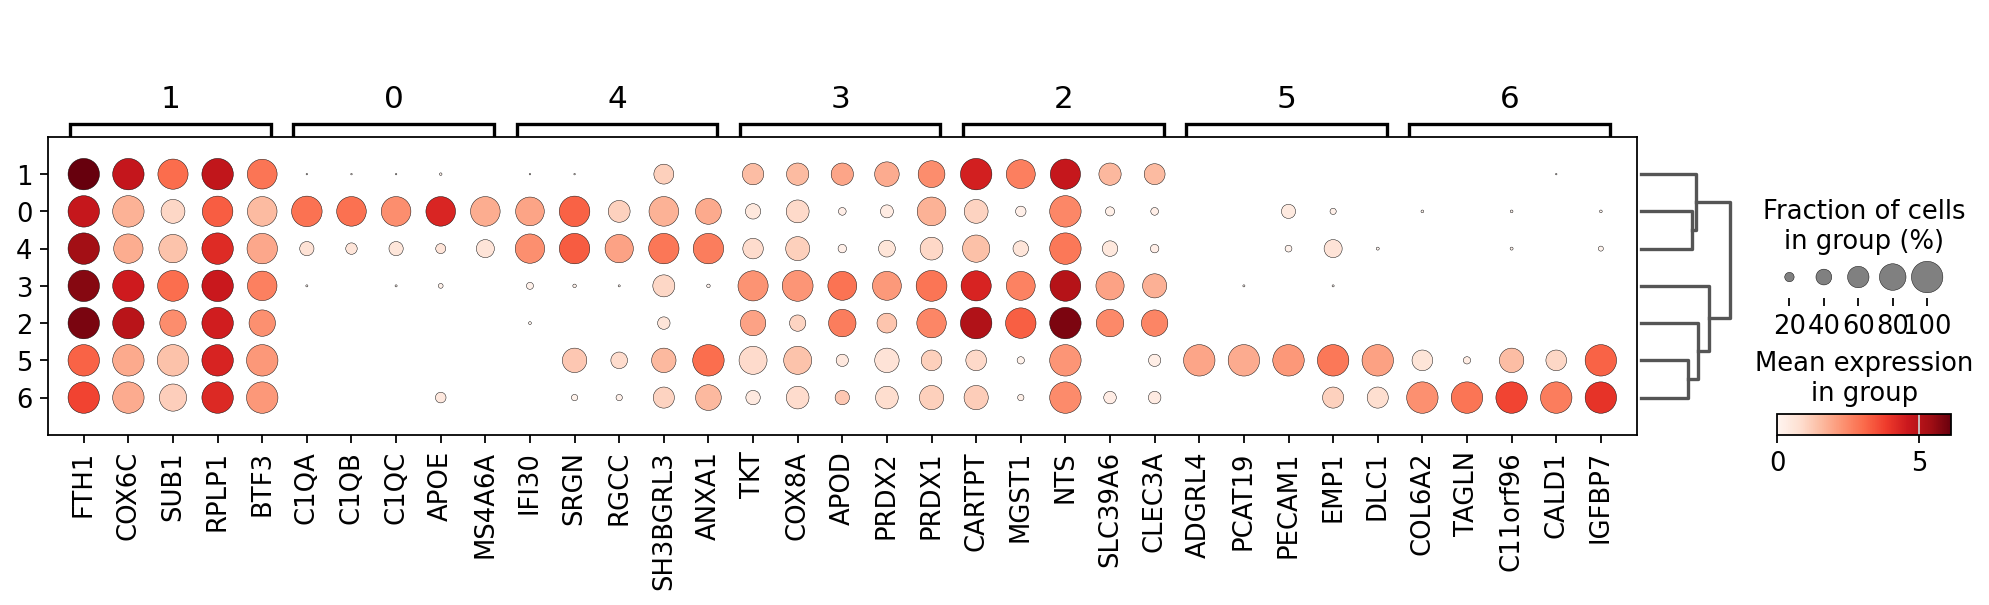

In [122]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key="wilcoxon", groupby="leiden")

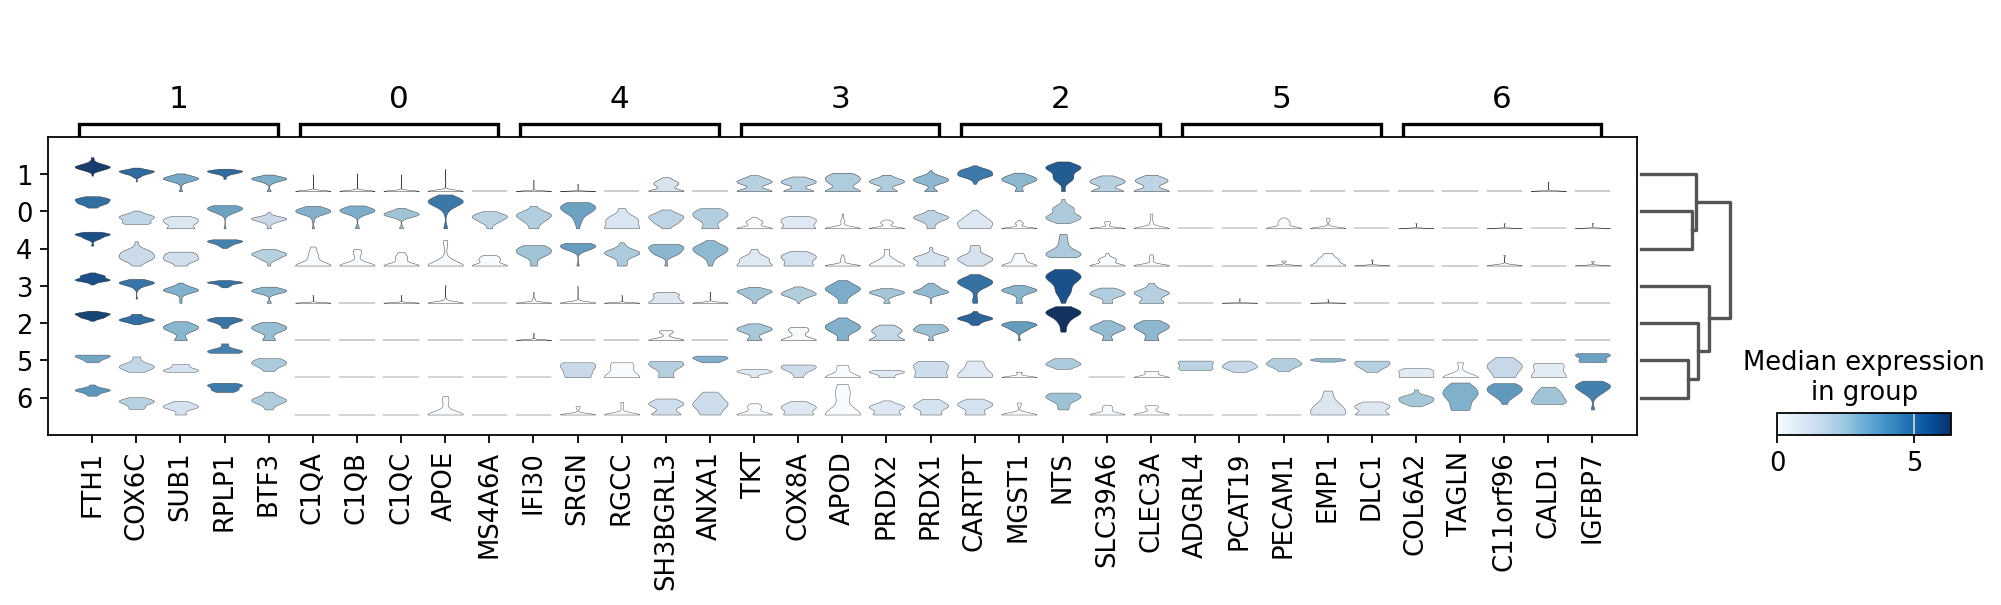

In [123]:
sc.pl.rank_genes_groups_stacked_violin(adata, n_genes=5, key="wilcoxon", groupby="leiden")

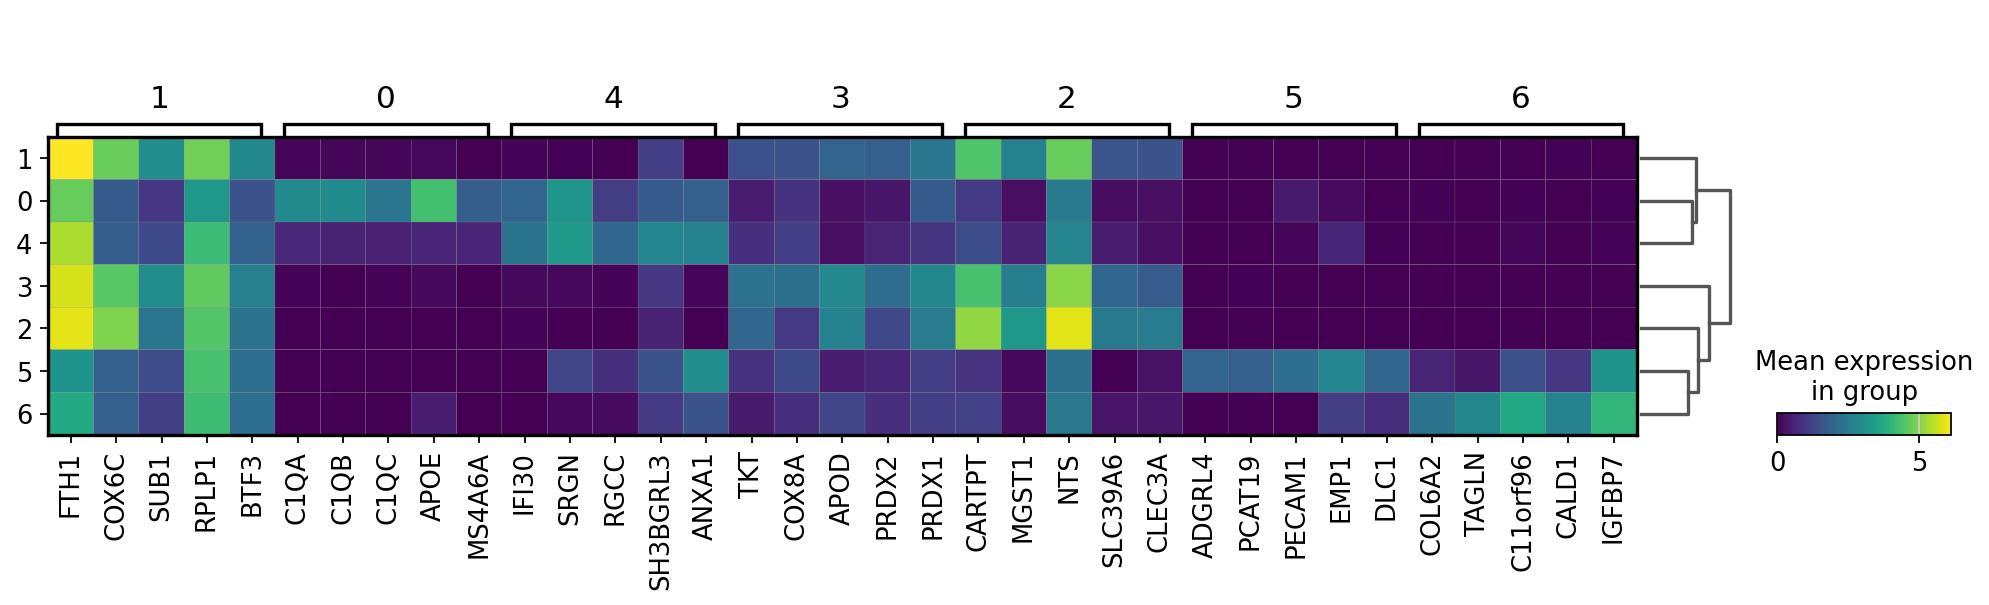

In [124]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="leiden")

### Cluster Annotation

In [182]:
marker_genes = ['ACTB', 'UBE2C', 'TFRC', 'SRRM2', 'FOXM1', 'HLA-DRB1', 'SPP1',
                'SMARCE1', 'MNX1', 'ADCY5', 'HOXC11', 'ANKRD22',
                'MKI67', 'CD9', 'CCNB1', 'MYBL2', 'MARCKS']

In [183]:
adata = sc.read(results_file)

In [185]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

0      1        2      3         4       5         6
0    C1QA   FTH1   CARTPT    TKT     IFI30  ADGRL4    COL6A2
1    C1QB  COX6C    MGST1  COX8A      SRGN  PCAT19     TAGLN
2    C1QC   SUB1      NTS   APOD      RGCC  PECAM1  C11orf96
3    APOE  RPLP1  SLC39A6  PRDX2  SH3BGRL3    EMP1     CALD1
4  MS4A6A   BTF3   CLEC3A  PRDX1     ANXA1    DLC1    IGFBP7

In [186]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

0_n           0_p    1_n           1_p      2_n           2_p    3_n  \
0    C1QA  2.681849e-14   FTH1  4.571550e-10   CARTPT  4.495195e-07    TKT   
1    C1QB  1.351841e-13  COX6C  8.168929e-10    MGST1  1.227020e-06  COX8A   
2    C1QC  1.700610e-13   SUB1  2.901427e-09      NTS  3.690163e-06   APOD   
3    APOE  2.137399e-13  RPLP1  1.131980e-08  SLC39A6  1.798793e-05  PRDX2   
4  MS4A6A  2.328162e-13   BTF3  5.262525e-08   CLEC3A  2.204598e-05  PRDX1   

            3_p       4_n           4_p     5_n       5_p       6_n  \
0  5.852583e-07     IFI30  6.033079e-10  ADGRL4  0.000007    COL6A2   
1  8.883804e-07      SRGN  6.595949e-10  PCAT19  0.000007     TAGLN   
2  3.835233e-06      RGCC  7.780305e-10  PECAM1  0.000009  C11orf96   
3  7.662866e-06  SH3BGRL3  1.224873e-09    EMP1  0.000011     CALD1   
4  8.152274e-06     ANXA1  1.423295e-09    DLC1  0.000011    IGFBP7   

            6_p  
0  1.091870e-11  
1  1.240161e-11  
2  1.364156e-11  
3  2.122893e-11  
4  2.260591e-11

ranking genes
    finished (0:00:00)


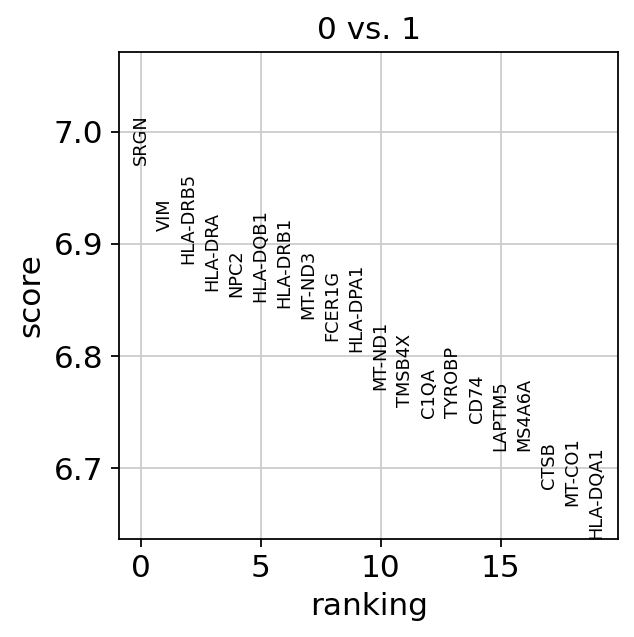

In [187]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


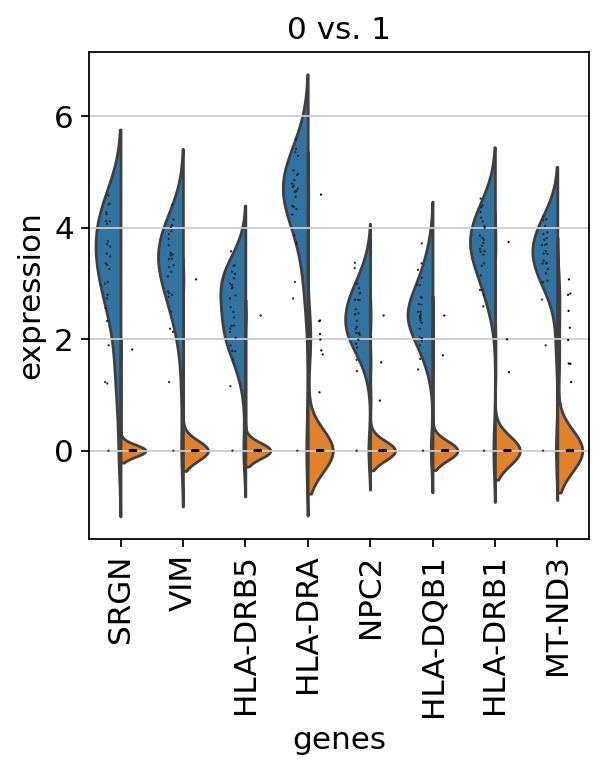

In [188]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

In [189]:
adata = sc.read(results_file)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


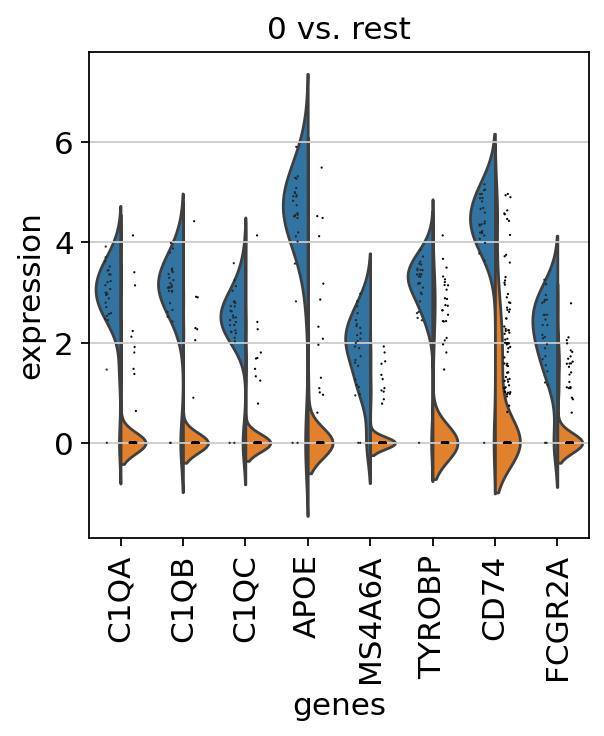

In [190]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

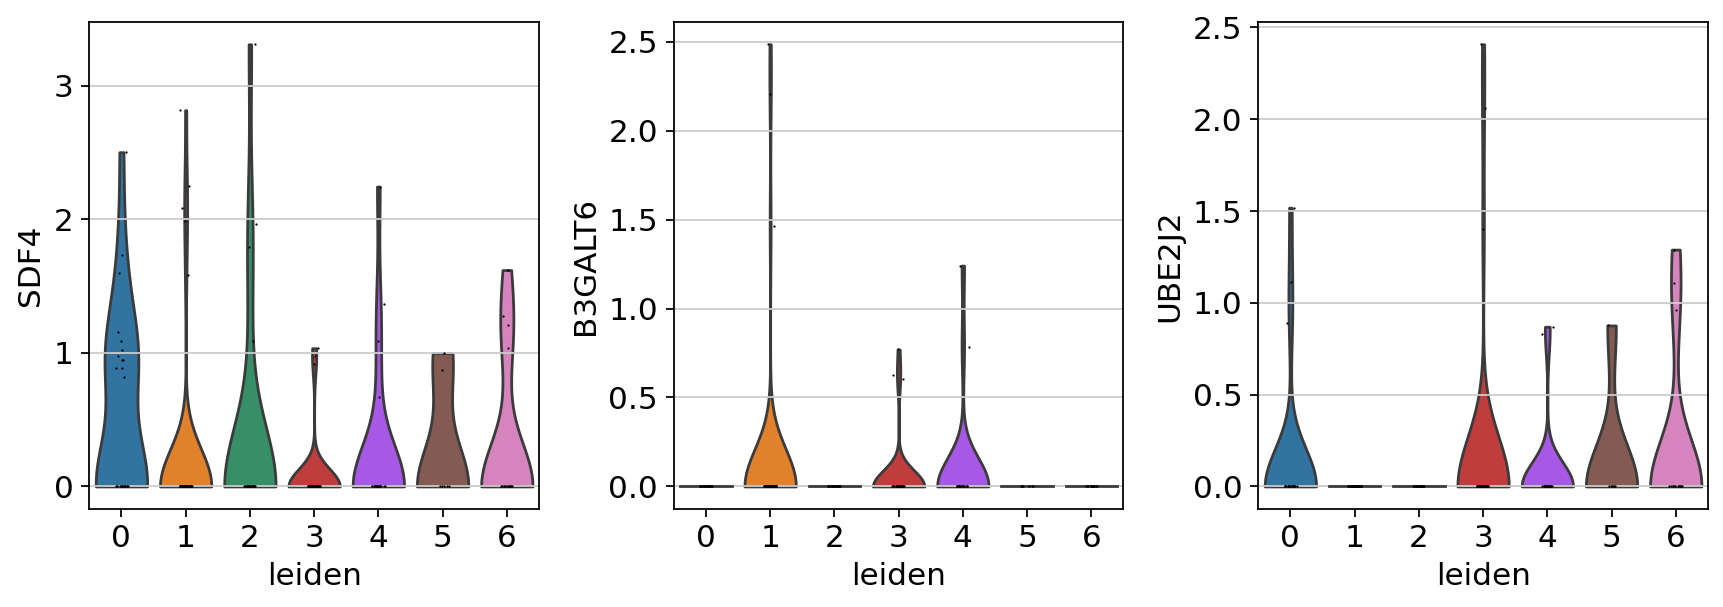

In [191]:
sc.pl.violin(adata, ["SDF4", "B3GALT6", "UBE2J2"], groupby="leiden")

In [192]:
adata.obs["leiden"].cat.categories.size

7

In [193]:
new_cluster_names = [
    'Metabolic protein', 'Transcription factor',
    'Plasma protein', 'Tranporters',
    'Enzymes', 'Membrane proteins',
    'Pericytes'
]
adata.rename_categories("leiden", new_cluster_names)

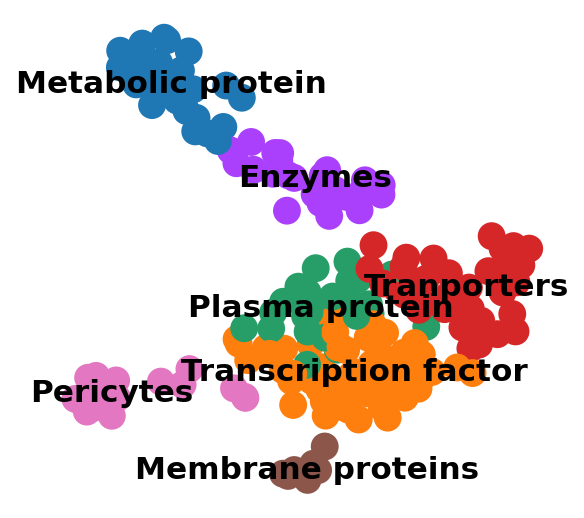

In [194]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

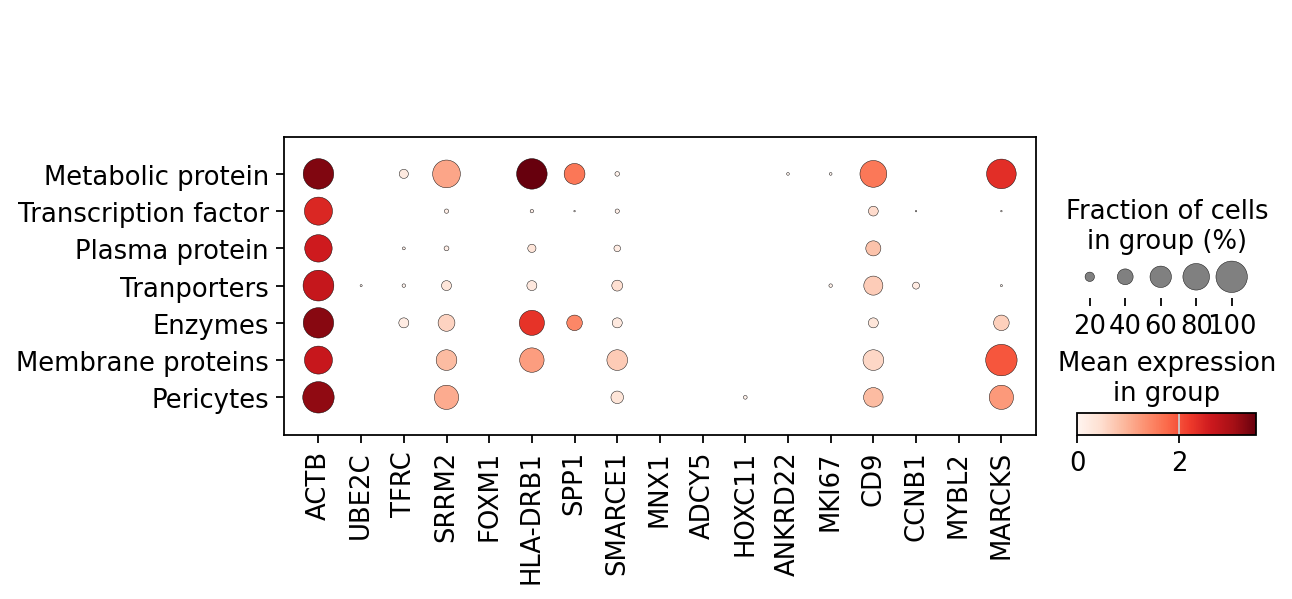

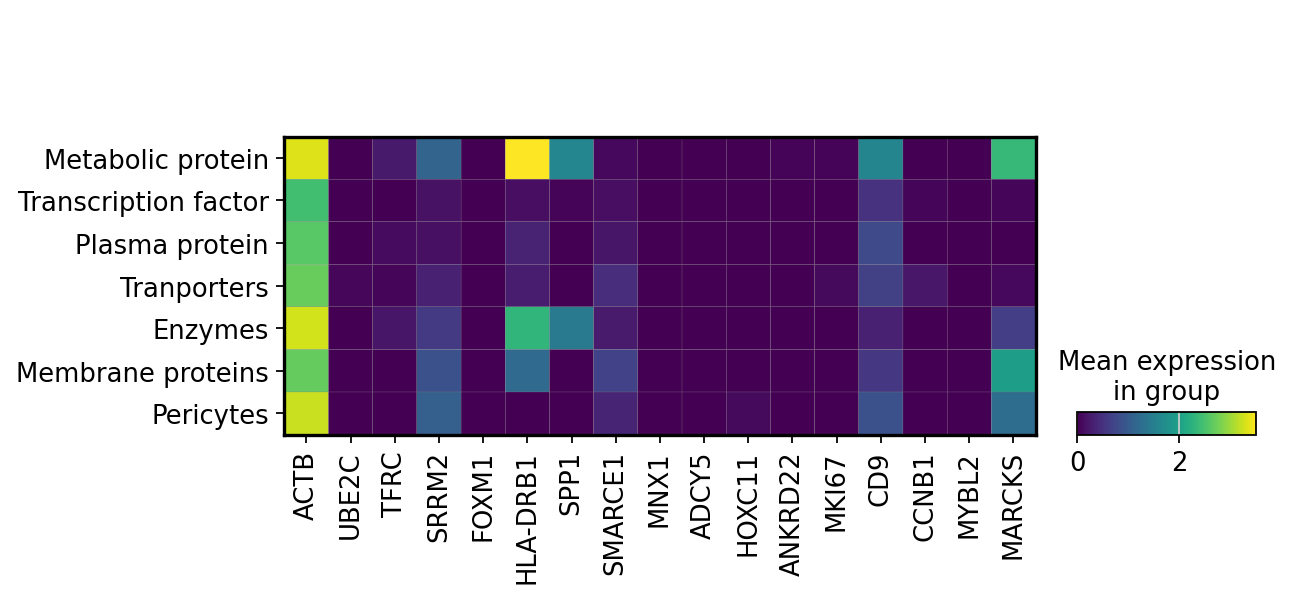

In [196]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');
sc.pl.matrixplot(adata, marker_genes, groupby="leiden")